## Two-layer perceptron 

Solve the XOR problem using a 2-layer perceptron


In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)

$x$ is an $p \times N$ matrix containing all the N-dimensional input vectors for each of the p patterns. Conventions are different than in the previous notebook, we pick $N=2$ so x is a 2-dimensional input. In the previous notebook, we had set $x[0]=-1$ and $w[0]$ was a fixed threshold, but we set the threshold explicitly.

$t$ is a vector of length p containing the targets for each training pattern, each target $\in$ {0,1}

We can choose two options: linearly separable patterns, or nonseparable patterns

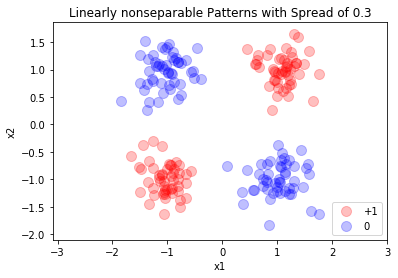

In [2]:
def generate_patterns(spread,N=2,p1=100,p2=100,option='separable',plot=False):

    # generate targets
    t=np.ones((p1+p2))# targets
    t[p1:]=0 # t2=0 targets
    x=np.zeros((p1+p2,N))
    
    # generate inputs
    if option=='separable':
        # separable targets
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
    elif option=='nonseparable':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]
    elif option=='weird':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]+1.5
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]+1
        t=np.ones((p1+p2))# targets
        t[0:int(p1/2)]=0; t[p1:int(p1+p2/2)]=0

    # make a figure
    if plot == True:
        fig,ax=plt.subplots()
        plt.title('Linearly {} Patterns with Spread of {}'.format(option,spread))
        size=100
        # scatterplot
        ax.scatter(x[t==1,0],x[t==1,1],s=size,color='red',alpha=0.25,label='+1')
        ax.scatter(x[t==0,0],x[t==0,1],s=size,color='blue',alpha=0.25,label='0')
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax.legend(loc='lower right')
        ax.axis('equal')  
    return x,t  

x,t=generate_patterns(spread=0.3,N=2,p1=100,p2=100,option='nonseparable',plot=True)

## Activity rule and cost function
Activity: 
$$
f(h)={1\over 1+e^{-h}}
$$

Log-likelihood function: 
$$
G(t^\mu|x^\mu_i,w_i)=-\sum_{\mu=1}^p\left[t^\mu\ln f(h^\mu)+(1-t^\mu)\ln(1- f(h^\mu))\right]\ , \,\,h^\mu=\sum_{i=1}^Nw_ix_i^\mu+b
$$

Log-posterior: 
$$
M(w_i|t^\mu,x^\mu_i)=G(t^\mu|x^\mu_i,w_i)+{1\over2}\alpha \sum_{i=1}^Nw_i^2
$$

In [3]:
def sigmoid(x,b,derivative=False):
    if np.prod(x.shape)>1: Nh,nx=x.shape 
    else: nx=1
    b_nx=np.tile(b,(nx,1)).T
    h=x+b_nx
    out=1/(1+np.exp(-h))
    return out*(1-out) if derivative else out

def Gfunc(yy,tt):
#         error function, careful when log argument hits zero
    tcols=tt.reshape(1,yy.shape[1])
    infy=~np.isinf(np.log(yy))
    infym=~np.isinf(np.log(1-yy))
    out=-tcols[infy].dot(np.log(yy)[infy])-(1-tcols[infym]).dot(np.log(1-yy)[infym])
    return out

## Batch training using backpropagation

We have inputs $x_i^\mu$, activations $h^{(m)}=\sum_{i_{m-1}} w^{(m)}_{i_m,i_{m-1}}x_{i_{m-1}}-\theta^{(m)}$ in layers $m=1,2$, and weights $w^{(m)}_{i_m,i_{m-1}}$ from layer $m-1$ to layer $m$; $\theta^{(m)}$ is the threshold. We will first propagate activity forward with $w$, then compute the errors $\delta^{(m)}$. In the case of only one pattern $\mu$ we have

$$
\delta^{(2)}= (t^\mu-O^\mu) \ ,
$$
$$
\delta^{(1)}_{i_1}=\delta^{(2)}[w^{(2)}]^T_{i_1}f'^{(1)}_{i_1}
$$

then propagate the errors backwards with $w^T$.

$$
\Delta w^{(2)}_{i_1}=\eta\left[\delta^{(2)}f^{(1)}_{i_1}-\alpha_1 w^{(2)}_{i_1}\right]
$$
$$
\Delta w^{(1)}_{i_1,i_0}=\eta\left(\delta^{(1)}_{i_1}x^\mu_{i_0}-\alpha_2 w^{(1)}_{i_1,i_0}\right)
$$

Try the following:
- Initialize biases $\theta^{(1)},\theta^{(2)}=1$, initialize weights from gaussian distributions with mean 0 and standard deviation 1. Can you classify the nonseparable patterns?
- Try increasing the size of the hidden layer, does that help?
- Solve the XOR problem for a network with 2 layers, with 2 units in the hidden layer and one unit in the top layer. Find the conditions on values of the weights and thresholds that give the correct classification. Now, initialize weights and thresholds as gaussians with mean equal to the new found value, and standard deviation 0.5. Can you learn the nonseparable patterns?


initial weights
w1_0 [[ 1.11513707 -0.27438041]
 [ 0.28445205  0.96440015]]
w2_0 [[-0.53952853  0.34341581]]
0 steps, delta1:-7.03e-04, delta2:-1.35e-01, error:1.46e+02, misclass:0.5
1000 steps, delta1:-9.64e-03, delta2:5.05e-02, error:1.30e+02, misclass:0.36
2000 steps, delta1:-6.83e-03, delta2:5.26e-02, error:1.29e+02, misclass:0.325
3000 steps, delta1:-6.42e-03, delta2:5.29e-02, error:1.29e+02, misclass:0.325
4000 steps, delta1:-6.32e-03, delta2:5.29e-02, error:1.29e+02, misclass:0.325
5000 steps, delta1:-6.28e-03, delta2:5.29e-02, error:1.29e+02, misclass:0.325
6000 steps, delta1:-6.26e-03, delta2:5.29e-02, error:1.29e+02, misclass:0.325
7000 steps, delta1:-6.26e-03, delta2:5.29e-02, error:1.29e+02, misclass:0.325
8000 steps, delta1:-6.25e-03, delta2:5.29e-02, error:1.29e+02, misclass:0.325
9000 steps, delta1:-6.25e-03, delta2:5.29e-02, error:1.29e+02, misclass:0.325
final weights
w1 [[ 1.51272018 -1.88557063]
 [ 1.87816227  2.41555465]]
w2 [[-0.78054961 -0.67194042]]


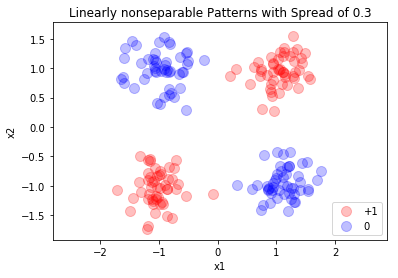

In [21]:
x,t=generate_patterns(spread=0.3,N=2,p1=100,p2=100,option='nonseparable',plot=True)

T=10000 # training steps
stepPlot=T/100 # take a snapshot of learning
eta=0.001 # learning rate
alpha=[0.1,0.2]#[0.1,0.2] # weight decay

# architecture
L=2 # layers
N=2 # inputs
Nh=2# number of hidden units
nunits=np.array([N,Nh,1],np.int) # number of units per layer
# threshold in each layer
theta1=np.ones((Nh)); theta1[0]=-1 #theta1=np.ones((Nh)) #theta1=np.ones((Nh)); theta1[0]=-1 
theta2=np.array(0.5)#theta2=np.ones((1)) #theta2=np.array(0.5)
# initialize the weights
w10=0.5*np.random.randn(nunits[0]*nunits[1]).reshape(nunits[1],nunits[0])
w20=0.5*np.random.randn(nunits[1]*nunits[2]).reshape(nunits[2],nunits[1]); w20[-1]=-w20[-1]
# w10=1+0.5*np.random.randn(nunits[0]*nunits[1]).reshape(nunits[1],nunits[0])
# w20=1+0.5*np.random.randn(nunits[1]*nunits[2]).reshape(nunits[2],nunits[1]); w20[-1]=-w20[-1]
print('initial weights')
print('w1_0 %s' % w10)
print('w2_0 %s' % w20)

# train network
h0=x.T # input patterns
Gplot=[]; yplot=[]; wplot1=[]; wplot2=[]; delta1plot=[]; delta2plot=[]; xplot=[]; errorfracplot=[];

for step in range(T):
    if step==0: w1=w10; w2=w20; # initial weights
    # propagate the activity forward
    # layer 1
    h1=w1.dot(h0)
    y1=sigmoid(h1,theta1)
    # layer 2
    h2=w2.dot(y1)
    y2=sigmoid(h2,theta2)
    # compute the errors and backpropagate them
    delta2=t-y2 # cols=number of patterns, rows=1
    delta1=np.tile(delta2,(h1.shape[0],1))*np.tile(w2.T,(1,h1.shape[1]))*sigmoid(h1,theta1,derivative=True)
    # update the weights
    w2=w2+eta*(delta2.dot(y1.T)-alpha[1]*w2)
    w1=w1+eta*(delta1.dot(h0.T)-alpha[0]*w1)
    errorfrac=sum(abs(np.round(y2)-t).flatten())/len(t)
    if step % stepPlot==0:
        gtemp=Gfunc(y2,t)
        Gplot.append(gtemp); yplot.append(y2); wplot1.append(w1); wplot2.append(w2)
        delta1plot.append(delta1.mean()); delta2plot.append(delta2.mean()); xplot.append(step)
        errorfracplot.append(errorfrac)
    if step % (10*stepPlot) ==0:
        print('{a1} steps, delta1:{a2:.2e}, delta2:{a3:.2e}, error:{a4:.2e}, misclass:{a5}'.format(a1=step,a2=delta1.mean(),a3=delta2.mean(),a4=gtemp,a5=errorfrac))
    if errorfrac==0:
        print('reached perfect accuracy at {a1} steps, misclass: {a2}'.format(a1=step, a2=errorfrac))
        break
    
print('final weights')
print('w1 %s' % w1)
print('w2 %s' % w2)

        


fraction misclassified: 0.325


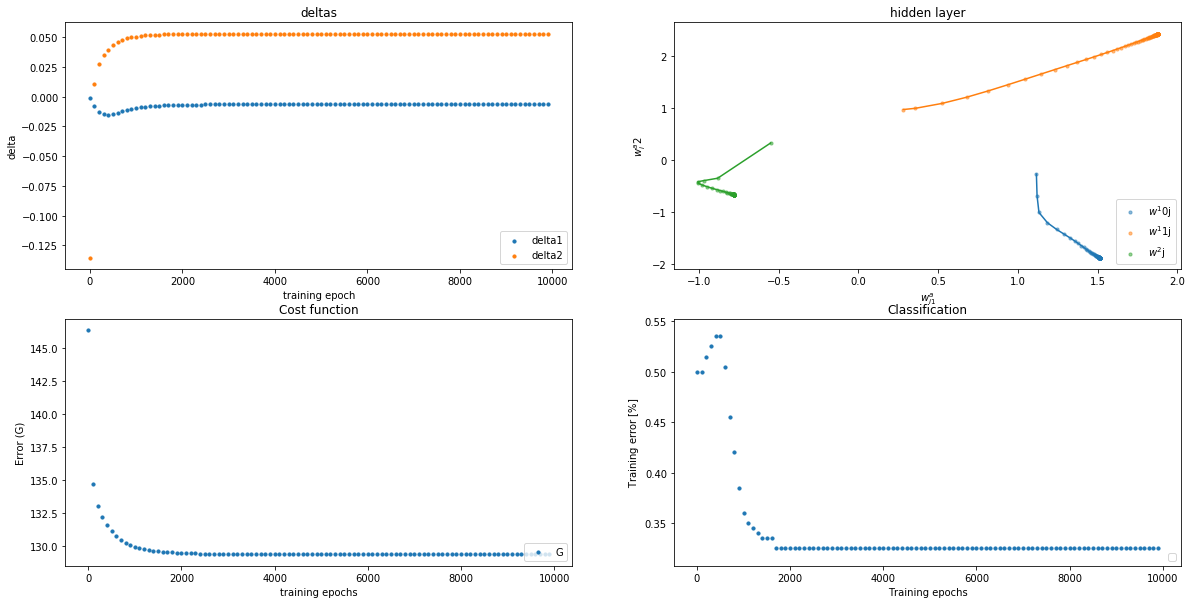

In [22]:
# monitor learning

T0=step # last ste[]
# plot
fig,ax=plt.subplots(2,2,figsize=(20,10))
# xplot=stepPlot*(np.arange(np.int(T0/stepPlot))+1)
xplot=np.array(xplot)

# plot delta
ax[0,0].scatter(xplot,delta1plot[:],s=10,label='delta1')
ax[0,0].scatter(xplot,delta2plot[:],s=10,label='delta2')
ax[0,0].legend(loc='lower right'); ax[0,0].set_xlabel('training epoch'); ax[0,0].set_ylabel('delta');  ax[0,0].set_title('deltas'); 

# EVOLUTION OF THE WEIGHTS
# hidden layer
for i in range(Nh):
    wplot=np.array(wplot1)[:,i,0:N]
    ax[0,1].scatter(wplot[:,0],wplot[:,1],s=10,label='$w^{1}$%sj' % (i),alpha=0.5)
    ax[0,1].plot(wplot[:,0],wplot[:,1])
#     ax[1].legend(loc='lower right'); ax[1].set_xlabel('weight1'); ax[1].set_ylabel('weight2'); ax[1].set_title('hidden layer'); 
# second layer
wplot=np.array(wplot2)[:,0,0:Nh]
ax[0,1].scatter(wplot[:,0],wplot[:,1],s=10,label='$w^2$j',alpha=0.5)
ax[0,1].plot(wplot[:,0],wplot[:,1])
ax[0,1].legend(loc='lower right'); ax[0,1].set_xlabel('$w^a_{i1}$'); ax[0,1].set_ylabel('$w^{a}_i2$'); ax[0,1].set_title('hidden layer'); 
# plot error
ax[1,0].scatter(xplot,np.array(Gplot),s=10,label='G')
ax[1,0].legend(loc='lower right'); ax[1,0].set_xlabel('training epochs'); ax[1,0].set_ylabel('Error (G)'); ax[1,0].set_title('Cost function'); 
# plot fraction of misclassified input patterns
ax[1,1].scatter(xplot,np.array(errorfracplot),s=10,label='')
ax[1,1].legend(loc='lower right'); ax[1,1].set_xlabel('Training epochs'); ax[1,1].set_ylabel('Training error $[\%]$'); ax[1,1].set_title('Classification'); 

# fraction of misclassified input patterns
print('fraction misclassified: %s' % errorfrac.mean())

# Plot single neuron receptive fields
Check that the two hidden neurons perform x0_h=(x0 AND x1), x1_h=(x0 OR x1), and the output neuron performs x_out=x0_h AND NOT X1_h

[[ 1.51272023 -1.88557004]
 [ 1.87815065  2.41554095]]
[[-0.78054952 -0.67194013]]


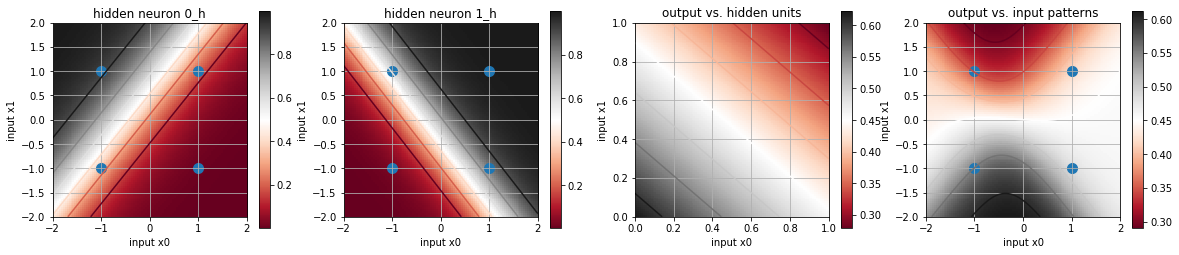

In [23]:
# trained weights
w1trained=np.array(wplot1)[len(xplot)-1] # rows=hidden units, cols=inputs
w2trained=np.array(wplot2)[len(xplot)-1] # rows=output, cols=hidden units
print(w1trained)
print(w2trained)
npoints=100
x1=np.linspace(-2,2,npoints)
x2=np.linspace(-2,2,npoints)
fig,ax=plt.subplots(1,Nh+2,figsize=(20,4))
# hidden units activations
for i_h in range(Nh):
    yplot=np.zeros((npoints,npoints))
    for i1 in range(npoints):
        for i2 in range(npoints):
            yplot[i1,i2]=sigmoid(w1trained[i_h].dot(np.array([x1[i1],x2[i2]])),theta1[i_h])
    surf1=ax[i_h].imshow(yplot,origin='lower',cmap='RdGy',extent=[np.min(x1),np.max(x1),np.min(x2),np.max(x2)])
    ax[i_h].contour(x1,x2,yplot,cmap='RdGy')
    fig.colorbar(surf1,ax=ax[i_h])
    ax[i_h].set_title("hidden neuron %s_h" % i_h)
    ax[i_h].set_xlabel("input x0"); ax[i_h].set_ylabel("input x1"); ax[i_h].grid()
    ax[i_h].scatter([1,1,-1,-1],[1,-1,1,-1],s=100)

# output as function of hidden units
yplot=np.zeros((npoints,npoints))
x1h=np.linspace(0,1,npoints)
x2h=np.linspace(0,1,npoints)
for i1 in range(npoints):
    for i2 in range(npoints):
        yplot[i1,i2]=sigmoid(w2trained.dot(np.array([x1h[i1],x2h[i2]])),theta2)
surf1=ax[Nh].imshow(yplot,origin='lower',cmap='RdGy',extent=[np.min(x1h),np.max(x1h),np.min(x2h),np.max(x2h)])
ax[Nh].contour(x1h,x2h,yplot,cmap='RdGy')
fig.colorbar(surf1,ax=ax[Nh])
ax[Nh].set_title("output vs. hidden units")
ax[Nh].set_xlabel("input x0"); ax[Nh].set_ylabel("input x1"); ax[Nh].grid()
# ax[Nh].scatter([1,1,-1,-1],[1,-1,1,-1],s=100)

# output unit as function of input patterns
yplot=np.zeros((npoints,npoints))
for i1 in range(npoints):
    for i2 in range(npoints):
        yhidden=np.zeros(Nh)
        for i_h in range(Nh):
            yhidden[i_h]=sigmoid(w1trained[i_h].dot(np.array([x1[i1],x2[i2]])),theta1[i_h])        
        yplot[i1,i2]=sigmoid(w2trained.dot(np.array(yhidden)),theta2)
surf1=ax[Nh+1].imshow(yplot,origin='lower',cmap='RdGy',extent=[np.min(x1),np.max(x1),np.min(x2),np.max(x2)])
ax[Nh+1].contour(x1,x2,yplot,cmap='RdGy')
fig.colorbar(surf1,ax=ax[Nh+1])
ax[Nh+1].set_title("output vs. input patterns")
ax[Nh+1].set_xlabel("input x0"); ax[Nh+1].set_ylabel("input x1"); ax[Nh+1].grid()
ax[Nh+1].scatter([1,1,-1,-1],[1,-1,1,-1],s=100)